In [56]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

# Example scenario

"Hey Bob, we're asking people to install this browser plugin. It reports to us every day if you visit https://uvm.edu/ and we release the counts of everyone who visits it, by day. But don't worry. We're using differential privacy. We'll add enough noise so no one will know if you visit it _on any particular day_. Are you in?"

Bob is in. He visits https://uvm.edu/ every day for a while, and then not at all.

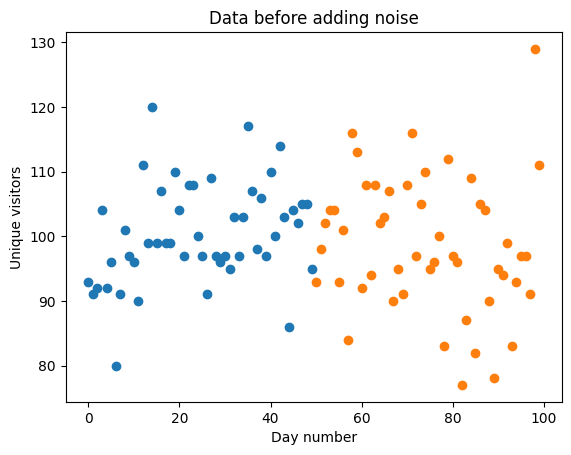

In [57]:
days_with = 50
days_without = 50
unique_visitors_with_bob = np.random.poisson(lam=100, size=days_with) + 1
unique_visitors_without_bob = np.random.poisson(lam=100, size=days_without)

plt.scatter(range(days_with), unique_visitors_with_bob)
plt.scatter(range(days_with, days_with + days_without), unique_visitors_without_bob)
plt.title('Data before adding noise')
plt.xlabel('Day number')
plt.ylabel('Unique visitors')
plt.show()

Researchers add noise to make unique visitor counts by user-day.

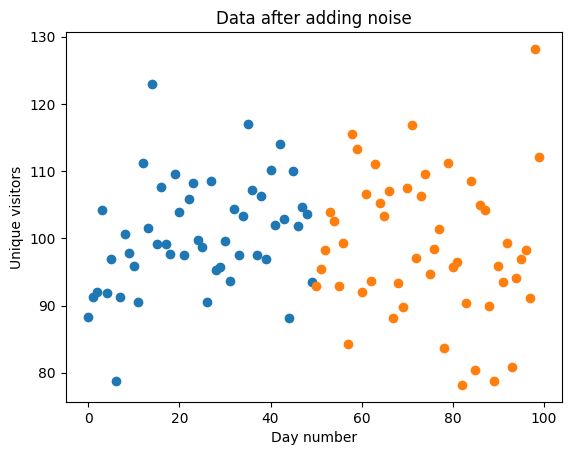

In [58]:
epsilon = 1
unique_visitors_with_bob = np.random.laplace(scale=1 / epsilon, size=days_with) + unique_visitors_with_bob
unique_visitors_without_bob = np.random.laplace(scale=1 / epsilon, size=days_without) + unique_visitors_without_bob

plt.scatter(range(days_with), unique_visitors_with_bob)
plt.scatter(range(days_with, days_with + days_without), unique_visitors_without_bob)
plt.title('Data after adding noise')
plt.xlabel('Day number')
plt.ylabel('Unique visitors')
plt.show()

To test that Bob's visits _by day_ are really protected, we shouldn't see a statistically significant difference between the days when Bob visited the site and when he didn't.

In [59]:
tval, pval = stats.ttest_ind(unique_visitors_with_bob, unique_visitors_without_bob, alternative='greater')
pval


0.16215938337762525

The p-values are varying really widely here, so I think something's not right. Sample sizes too small? Fundamental misunderstanding of user-day privacy guarantee?

# Relating epsilon and alpha

So here's what I'm really interested in, and what I wrote this notebook for. Epsilon is a measurement of how much information gets released, but it's an abstract measurement in the sense that it's difficult to understand what impact the choice of epsilon could have in a real world scenario. In the case of these counts, alpha is us choosing at which p-value we say the difference is big enough that we've identified Bob. Epsilon and alpha (really, the p-value I guess) have to be related, right?

Let's see...

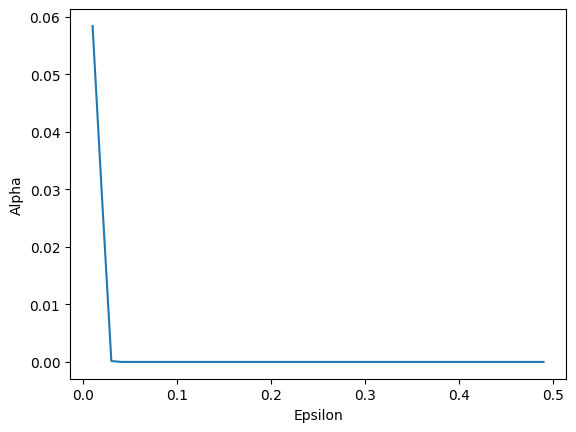

In [89]:
size_1 = 100000
size_2 = 100000
epsilons = [x / 100 for x in range(1, 50)]
alphas = []

for epsilon in epsilons:
    sample_1 = np.random.laplace(scale=1 / epsilon, size=size_1) + np.random.poisson(lam=10, size=size_1) + 1
    sample_2 = np.random.laplace(scale=1 / epsilon, size=size_2) + np.random.poisson(lam=10, size=size_2)
    
    # No one participates except Bob variation
    #sample_1 = np.random.laplace(scale=1 / epsilon, size=size_1) + 1
    #sample_2 = np.random.laplace(scale=1 / epsilon, size=size_2)

    tval, pval = stats.ttest_ind(sample_1, sample_2, alternative='greater')
    alphas.append(pval)

plt.plot(epsilons, alphas)
plt.xlabel('Epsilon')
plt.ylabel('Alpha')
plt.show()

All in all, I'm surprised by how quickly alpha goes down here since 0.05 is a pretty typical value to choose for research. I'm quite rusty with stats though, and it's certainly possible I'm doing something wrong. There's a lot more variability with smaller sample size. The lambda parameter on the Laplace distribution also seems to matter a lot.

# More questions

1. Do the sample sizes matter?
2. Do the relative sample sizes matter?
3. Does the distribution or the distribution params of the data matter?
4. What happens if no one but Bob visits the site, ever?
5. Is there a formula for the relationship between epsilon and alpha?